## Description
Author: shuheng.mo21@imperial.ac.uk (sm321@ic.ac.uk)          

This notebook contains the parallelisation of 2D Advection-diffusion equation implemented with MPI (mpi4py). The script within this notebook is converted to Python scripts and presented at [here](https://github.com/ese-msc-2021/irp-sm321/tree/main/code).          


## Prerequisites

Datatypes map between mpi4py and the numpy:(reference: https://groups.google.com/g/mpi4py/c/u33WWWKThDs)        
```
typemap = {
        np.dtype(np.float64) : MPI.DOUBLE,
        np.dtype(np.float32) : MPI.FLOAT,
        np.dtype(np.int)     : MPI.INT,
        np.dtype(np.int8)    : MPI.CHAR,
        np.dtype(np.uint8)   : MPI.UNSIGNED_CHAR,
        np.dtype(np.int32)   : MPI.INT,
        np.dtype(np.uint32)  : MPI.UNSIGNED_INT,
    }
```

Note: we can pass numpy datatypes into Tensorflow tensor.  
Please remember to install the required dependencies below.

In [ ]:
## Install the required dependencies
! python -m pip install mpi4py
! mkdir output
! mkdir norms
! mkdir serial_steps
! mkdir parallel_steps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 14.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185292 sha256=2f733bd82b6c16bd3e4546d172e337297578f027f525d9bcdd8872b8f2cbf15c
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


## Problem Details
Boyang et al. have implemented the [CFD model](https://www.imperial.ac.uk/people/c.heaney/document/9723/AI_for_CFD_v1b/?AI_for_CFD_v1b.pdf) for solving 2D advection-diffusion equation with TensorFlow. This notebook cited their implementation and was legally approved. The problem was formulated as below:                

$\frac{\partial T}{\partial t} + u\frac{\partial T}{\partial x}+ v\frac{\partial T}{\partial y}+ \sigma T- \nu \nabla^2T = s $.               

in which T is a scalar concentration field with size 300m by 300m,$t$ is time, ($u,v$) are the advection velocities.$\sigma$,$\nu$ and $s$ respectively are the absorption term, constant diffusivity and source term. Boundary conditions fixed zero solutions at the edges of the domain (No-flux boundary condition). Note for the equation formulated in this work, $\sigma = s = 0$ and advection velocity is fixed with ($1ms^{-1},1ms^{-1}$). So the expected pattern for those two initialised distributions are to be advected to the upper-right corner while diffused with constant coefficient.

alternatively the problem can be formulated as:

$\frac{\partial T}{\partial t} + u\frac{\partial T}{\partial x}+ v\frac{\partial T}{\partial y} = \nu \nabla^2T $. 


## Serial Code

In [1]:
# %%writefile serial_advection_diffusion_2D.py
%%writefile advection_diffusion_2D.py
## imports
import sys
assert sys.version_info >= (3,5)

import math

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import time
from mpi4py import MPI

################################ Load data and initial conditions #######################
# Load data and set initial condition
nx, ny = 300, 300
T = np.zeros([nx, ny], dtype=np.float64)
gamma = 40
# initialise t:
x0 = 0
y0 = -50
x = np.zeros([1, nx], dtype=np.float64)
y = np.zeros([1, ny], dtype=np.float64)

for ii in range(nx):
    x[0][ii] = -150 + 300/nx*ii
    y[0][ii] = -150 + 300/nx*ii

# boundary excluded: range 1-299 x 1-299, I suppose we are using Dirichlet boundary condition
for i in range(1, 299):
    for j in range(1, 299):
        temp1 = -((x[0][i] - x0)**2 + (y[0][j] - y0)**2)
        temp2 = 2*gamma**2
        T[i][j] = math.exp(temp1/temp2)

input_shape = (1, nx, ny, 1)  # (1,300,300,1) as original problem size

mesh = np.zeros(input_shape, dtype=np.float64) # default data type of np.zeros is np.float64

# generate Gaussian with a blob
for i in range(nx):
    for j in range(ny):
        mesh[0][i][j][0] = T[i][j]  # + Z1[i][j] + Z2[i][j] + Z3[i][j]*0.5

# generate Gaussian with a blob
for i in range(50):
    for j in range(50):
        mesh[0][i+225][j+125][0] = mesh[0][i+225][j+125][0] + 1

# values = tf.convert_to_tensor(mesh,dtype=np.float64)
values = mesh

################################ Initializations ####################################
start_time = time.perf_counter()

# weight matrices
w1 = ([[[[0.0],        # upwind
        [0.2],
        [0.0]],

        [[0.3],
        [-1.0],
        [0.2]],

        [[0.0],
        [0.3],
        [0.0]]]])

w2 = ([[[[0.0],        # central
        [0.15],
        [0.0]],

        [[0.25],
        [-0.8],
        [0.15]],

        [[0.0],
        [0.25],
        [0.0]]]])

# print(np.array(w1).shape) # shape (1,3,3,1)
init_kernel_1 = w1
init_kernel_2 = w2

init_bias = np.zeros((1,))  # filters - need change to exact value for bias

kernel_initializer_1 = tf.keras.initializers.constant(
    init_kernel_1)  # initializer which initialize constant tensor
kernel_initializer_2 = tf.keras.initializers.constant(init_kernel_2)

bias_initializer = tf.keras.initializers.constant(init_bias)

# CNN 2D layers: now I generate CNN filters for each subdomains
# filter 1
CNN2D_1 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(nx, ny, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                          #                                activation='relu',
                          kernel_initializer=kernel_initializer_1,
                          bias_initializer=bias_initializer),
    #         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
    #                                activation='relu',
    #                                kernel_initializer=kernel_initializer_2,
    #                                bias_initializer=bias_initializer),
])

# filter 2
CNN2D_2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(nx, ny, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                          #                                activation='relu',
                          kernel_initializer=kernel_initializer_2,
                          bias_initializer=bias_initializer),
    #         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
    #                                activation='relu',
    #                                kernel_initializer=kernel_initializer_2,
    #                                bias_initializer=bias_initializer),
])

# here set up the hyperparameters to tune in the later training process
CNN2D_1.compile(loss="mse",
                optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))
CNN2D_2.compile(loss="mse",
              optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))

l1_norms = np.array([])
l2_norms = np.array([])
linf_norms = np.array([])

for t in range(1000):
    # one-step
    # a = CNN2D_2.predict(values)
    # values += a

    # two-step scheme with central scheme
    a = CNN2D_2.predict(values)
    b = (a + values)
    c = (b + values)*0.5
    d = CNN2D_2.predict(c)
    values += d

    # if t %10 == 0: # save the l1 norm and l2 norm of result per 10 timesteps
    #l1_norms = np.append(l1_norms, np.linalg.norm(values.reshape(300,300), ord=1)/90000)
    #l2_norms = np.append(l2_norms, np.linalg.norm(values.reshape(300,300), ord=2)/90000)
    #linf_norms = np.append(linf_norms, np.linalg.norm(values.reshape(300,300), ord=np.inf)/90000)
    #np.save("/content/serial_steps/AD_2D_serial_step_{}".format(t),values.reshape(nx, ny))

#  Visualization omitted
#    if t == 0:
#        plt.imshow(values[0,:,:,0], vmin=0, vmax=1.0)
#        plt.axis('off')
#        fig1_name = "paper_figure/figure_1/up_2nd_"+str(t)+".jpg"
#        plt.savefig(fig1_name, dpi=200, bbox_inches='tight')
#        plt.close()
#    elif t ==250 or t == 500 or t == 1000:
#        plt.imshow(values[0,:,:,0], vmin=0, vmax=1.0)
#        plt.axis('off')
#        fig1_name = "paper_figure/figure_1/up_2nd_"+str(t)+".jpg"
#        plt.savefig(fig1_name, dpi=200, bbox_inches='tight')
#        plt.close()


end_time = time.perf_counter()
print(f"[INFO] Problem solved in {end_time - start_time:0.4f} seconds using serial solution.")

# save the final result to text file
np.save("/content/output/AD_2D_serial", values.reshape(nx,ny))
# np.save("/content/norms/AD_2D_serial_l1_norms", l1_norms)
# np.save("/content/norms/AD_2D_serial_l2_norms", l2_norms)
# np.save("/content/norms/AD_2D_serial_linf_norms", linf_norms)

Writing advection_diffusion_2D.py


In [ ]:
# run the serial code
! python serial_advection_diffusion_2D.py 

2022-09-02 01:35:57.128441: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
[INFO] Problem solved in 70.4644 seconds using serial solution.
[fbd082a9ae99:00406] *** Process received signal ***
[fbd082a9ae99:00406] Signal: Segmentation fault (11)
[fbd082a9ae99:00406] Signal code: Address not mapped (1)
[fbd082a9ae99:00406] Failing at address: 0x7f4a09fb620d
[fbd082a9ae99:00406] [ 0] /lib/x86_64-linux-gnu/libpthread.so.0(+0x12980)[0x7f4a0ca5b980]
[fbd082a9ae99:00406] [ 1] /lib/x86_64-linux-gnu/libc.so.6(getenv+0xa5)[0x7f4a0c69a775]
[fbd082a9ae99:00406] [ 2] /usr/lib/x86_64-linux-gnu/libtcmalloc.so.4(_ZN13TCMallocGuardD1Ev+0x34)[0x7f4a0cf05e44]
[fbd082a9ae99:00406] [ 3] /lib/x86_64-linux-gnu/libc.so.6(__cxa_finalize+0xf5)[0x7f4a0c69b605]
[fbd082a9ae99:00406] [ 4] /usr/lib/x86_64-linux-gnu/libtcmalloc.so.4(+0x13cb3)[0x7f4a0cf03cb3]
[fbd082a9ae99:00406] *** End of error message ***


## MPI subroutines
All functions for communicating halos (2D, and perhaps 3D) has been encapsulated in Python subroutine named as halo_exchange.py. It will be called to parallelize the corresponding code.

In [ ]:
# %%writefile halo_exchange.py

# imports
import os
import sys
import numpy as np  # cupy can be used as optimisation if CUDA/AMD GPUs are available
from tensorflow import keras
import tensorflow as tf
import math
from mpi4py import MPI

assert tf.__version__ >= "2.0"
np.set_printoptions(threshold=sys.maxsize) # print out the full numpy array

############################## Global variables ################################
comm = None               # MPI communicator
rank = 0                  # Process rank    
num_process = 1           # Number of processors
rows,cols = 1,1           # Cartesian topology for 2D structured mesh
sub_nx, sub_ny, sub_nz = 0,0,0 # Dimensions for sub-domain up to 3D
neighbors = [-2, -2, -2, -2, -2, -2] # Process rank for all neighboring subdomains
current_vector = None     # 1D Block structured sub-domain
current_domain = None     # 2D Block Structured sub-domain
current_cube = None       # 3D Block Structured sub-domain
is_double_precision = False   # variable control the precision of MPI communication buffer vlaues
is_diagonal_exchange = False  # control do we need exchange values on corners

# TODO: the best practice is to use OOP
# class halo_exchange:
#   # initialization
#   def __init__(self) -> None:

#   # member functions
  
############################## Util functions ##################################
# clear the cached subdomain to release memory
def clear_cache():
  global current_domain, current_cube
  if current_domain != None:
    del current_domain
  if current_cube != None:
    del current_cube

def id_2_idx(rank, cols):
    """
    return the indices of processor in processor
    grid space based on the processor ranks

    Parameters
    ----------
    rank : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    return rank/cols, rank % cols

def idx_2_id(rows, cols, id_row, id_col):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    if id_row >= rows or id_row < 0:
        return -1
    if id_col >= cols or id_col < 0:
        return -1
    return id_row * id_col + id_col

def generate_dimension_2D(num_process):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    global rows,cols
    rows,cols = 0,0
    min_gap = num_process
    max_val = int(num_process**0.5 + 1)
    for i in range(1, max_val+1):
        if num_process % i == 0:
            gap = abs(num_process/i - i)
            if gap < min_gap:
                min_gap = gap
                rows = i
                cols = int(num_process / i)

    return rows, cols

def generate_dimension_3D(num_process):
  # TODO: generate dimension for 3D processor grid space
  pass

def domain_decomposition_strip(mesh, num_process):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    sub_domains = np.hsplit(mesh, num_process)
    return sub_domains

def domain_decomposition_grid(mesh, rows, cols):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    nx, ny = mesh.shape
    assert nx % rows == 0, f"{nx} rows is not evenly divisible by {rows}"
    assert ny % cols == 0, f"{ny} cols is not evenly divisible by {cols}"
    sub_nx = nx//rows
    sub_ny = ny//cols
    return (mesh.reshape(nx//sub_nx, sub_nx, -1, sub_ny)
            .swapaxes(1, 2)
            .reshape(-1, sub_nx, sub_ny))
    
def domain_decomposition_cube(mesh, proc_grid_dim):
  """
  return the rank of processor in processor
  grid space based on the indices

  Parameters
  ----------
  rows : int
      the rank of the process
  cols :
      the colun number of the process grid space

  Returns
  -------
  int
      x and y coordinate of the processor

  Raises
  ------
  None
  """
  global sub_nx,sub_ny,sub_nz
  nx, ny, nz = mesh.shape
  
  assert nx % proc_grid_dim[0] == 0, f"{nx} grids along x axis is not evenly divisible by {proc_grid_dim[0]}"
  assert ny % proc_grid_dim[1] == 0, f"{ny} grids along y axis is not evenly divisible by {proc_grid_dim[1]}"
  assert nz % proc_grid_dim[2] == 0, f"{nz} grids along z axis is not evenly divisible by {proc_grid_dim[2]}"
  
  sub_nx = nx // proc_grid_dim[0]
  sub_ny = ny // proc_grid_dim[1]
  sub_nz = nz // proc_grid_dim[2]

  new_shape = (sub_nx,sub_ny,sub_nz)
  num_cubes = np.array(mesh.shape) // new_shape
  split_shape = np.column_stack([num_cubes, new_shape]).reshape(-1)
  order = np.array([0,2,4,1,3,5])

  return mesh.reshape(split_shape).transpose(order).reshape(-1, *new_shape) # return a numpy array


def find_neighbours_id_2D(rank, rows, cols, proc_row_idx, proc_col_idx,num_process):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    # TODO: Consider the conditions in periodic boundaries (if required) 
    # left,right,top,bottom = find_neighbours_id(rank,rows,cols,proc_row_idx,proc_col_idx,num_process)
    # print("[INFO] Neighbors of process {}: left={},right={},up={},down={}".format(rank,left,right,top,bottom))
    left_neighbour = (rank - 1) if proc_col_idx != 0 and rank >=1 else MPI.PROC_NULL
    right_neighbour = (rank + 1) if proc_col_idx != (cols-1) and rank < num_process - 1 else MPI.PROC_NULL
    top_neighbour = (rank - cols) if proc_row_idx != 0 and (rank - cols) >=0 else MPI.PROC_NULL
    bottom_neighbour = (rank + cols) if proc_row_idx != (rows-1) and (rank + cols) <= num_process-1 else MPI.PROC_NULL

    return left_neighbour, right_neighbour, top_neighbour, bottom_neighbour

# padding halos to sub-domain manually
def padding_block_halo_1D(sub_domain,halo_size,halo_val = 0):
  if tf.is_tensor(sub_domain):
     sub_domain = sub_domain.numpy()

  if sub_domain.ndim > 1:
    sub_domain = np.squeeze(sub_domain,axis=0)
    sub_domain = np.squeeze(sub_domain,axis=-1)

  return np.pad(sub_domain,(halo_size,halo_size),'constant',constant_values=(halo_val,))

def padding_block_halo_2D(sub_domain,halo_size,halo_val = 0):
  if tf.is_tensor(sub_domain):
     sub_domain = sub_domain.numpy()

  if sub_domain.ndim > 2:
    sub_domain = np.squeeze(sub_domain)

  # note padding halo values with 0 by default
  return np.pad(sub_domain,(halo_size,halo_size),'constant',constant_values=(halo_val,))

# incase we need diff size of halos on each boudary
def padding_block_halo_2D_custom(sub_domain,halo_dim,halo_vals):
  pass 

def padding_block_halo_3D(sub_cube,halo_size,halo_val = 0):
  if tf.is_tensor(sub_cube):
    sub_cube = sub_cube.numpy()

  if sub_cube.ndim > 3:
    sub_cube = remove_one_dims(sub_cube)
  
  nx,ny,nz = sub_cube.shape

  # note padding halo values with 0 by default
  ans = np.pad(sub_cube,(halo_size,halo_size),'constant',constant_values=(halo_val,))
  return tf.convert_to_tensor(ans.reshape(1,nx+2,ny+2,nz+2,1))

# incase we need diff size of halos on each boudary
def padding_block_halo_3D_custom(sub_cube,halo_dim,halo_vals):
  pass 


# remove trivial 1 dimensions of the tensor.numpy()
def remove_one_dims(input):
  while input.ndim > 3:
      if input.shape[0] == 1:
          input = np.squeeze(input,axis = 0)
      if input.shape[-1] == 1:
          input = np.squeeze(input,axis = -1)
  return  input

############################## MPI Initialization ##############################
def mpi_initialization(proc_grid_dim,is_periodic,is_reordered):
  global rank,num_process,comm

  num_process = MPI.COMM_WORLD.Get_size() # get number of process
  assert num_process > 1, f"Parallelisation involves 2 or more processes, otherwise run implementation without MPI"

  # create Cartesian Topology
  comm = MPI.COMM_WORLD.Create_cart(
    proc_grid_dim,
    periods=is_periodic, # set True if periodic boundary
    reorder=is_reordered)
  
  # get the rank of current process
  rank = comm.rank

def domain_decomposition_1D(values, nx, is_periodic=False,is_reordered=True):
  global num_process,comm,rank, sub_nx, neighbors, current_vector
  LEFT = 0
  RIGHT = 1

  num_process = MPI.COMM_WORLD.Get_size() # get number of process
  proc_grid_dim = (num_process,)
  mpi_initialization(proc_grid_dim, is_periodic, is_reordered)

  neighbors[LEFT], neighbors[RIGHT] = comm.Shift(0, 1)

  # print("NEIGHBORS OF {} ".format(rank),neighbors)

  sub_domains = domain_decomposition_strip(values.reshape(nx,), num_process)  # (1,x)
  sub_nx = sub_domains[rank].shape[0]
  current_vector = np.pad(sub_domains[rank],(1,1),"constant",constant_values=(0,))

  return sub_nx, current_vector

# grid decomposition for 2D block structured meshes
def domain_decomposition_2D(values, nx, ny, is_periodic=(False,False),is_reordered=True):
  global comm,rank, sub_nx, sub_ny, neighbors,current_domain

  TOP = 0
  BOTTOM = 1
  LEFT = 2
  RIGHT = 3

  num_process = MPI.COMM_WORLD.Get_size() # get number of process
  proc_grid_dim = generate_dimension_2D(num_process)
  mpi_initialization(proc_grid_dim, is_periodic, is_reordered)

  if rows == 1 or cols == 1:
    sub_domains = domain_decomposition_strip(values.reshape(nx,ny), num_process)  # 2 process
    sub_nx, sub_ny = sub_domains[0].shape
  else:
    # if the process arrays is 2D then use grid decomposition to split domain
    sub_domains = domain_decomposition_grid(values.reshape(nx,ny), rows, cols)
    sub_nx, sub_ny = sub_domains[0].shape

  # create customized MPI datatype
  grid_size = [sub_nx,sub_ny]
  subdomain_size = [sub_nx+2, sub_ny + 2]
  start_indices = [1,1]

  # customised data type for 2D problem
  # comm_datatype = MPI.DOUBLE.Create_subarray(subdomain_size, grid_size, start_indices).Commit()

  # find the processor id of all neighboring processors
  neighbors[TOP], neighbors[BOTTOM] = comm.Shift(0, 1)
  neighbors[LEFT],  neighbors[RIGHT]  = comm.Shift(1, 1)

  current_domain = np.pad(sub_domains[rank],(1,1),"constant",constant_values=(0,))

  return sub_nx, sub_ny, current_domain

# grid decomposition for 3D block structured meshes
def domain_decomposition_3D(values, nx, ny, nz, is_periodic=(False,False,False),is_reordered=True):
  global rank, num_process, neighbors, current_cube

  # neighbor indices
  LEFT = 0
  RIGHT = 1
  FRONT = 2
  BEHIND = 3
  TOP = 4
  BOTTOM = 5

  num_process = MPI.COMM_WORLD.Get_size() # get number of process
  # TODO: create Cartesian topology for processes in 3D space
  proc_grid_dim = (2,2,2) # divide to 2x2x2, 8 subcubes
  #proc_grid_dim = (4,4,4) # divide to 4x4x4, 64 subcubes
  mpi_initialization(proc_grid_dim, is_periodic, is_reordered)
  
  # edge case, if 1 process we do nothing
  if num_process == 1:
    return nx,ny,nz,values

  if tf.is_tensor(values):
    sub_cubes = domain_decomposition_cube(tf.reshape(values,[nx,ny,nz]).numpy(),proc_grid_dim)
    # we can do this in complete tensorflow routines
    # current_cube = tf.convert_to_tensor(sub_cubes[rank], dtype=tf.float32)
    # paddings = tf.constant([[1, 1], [1, 1], [1, 1]])
    # current_cube = tf.pad(current_cube, paddings)
  else:
    sub_cubes = domain_decomposition_cube(values.reshape(nx,ny,nz),proc_grid_dim) # if it is numpy reshape directly

  # create customized MPI datatype
  cube_size = [sub_nx,sub_ny,sub_nz]
  subcube_size = [sub_nx+2, sub_ny + 2, sub_nz + 2]
  start_indices = [1,1,1]

  # use datatypes with 64 bits
  # comm_datatype_3D = MPI.DOUBLE.Create_subarray(subcube_size, cube_size, start_indices).Commit()

  # padding the halo grids
  current_cube = np.pad(sub_cubes[rank],(1,1),'constant',constant_values=(0,))

  # print("[CURRENT_CUBE_SHAPE of {}]".format(rank), current_cube.shape)


  # find neighbors (note here 0,1,2 are x,y,z coordinates respectively)
  neighbors[LEFT], neighbors[RIGHT] = comm.Shift(2, 1)
  neighbors[FRONT],  neighbors[BEHIND]  = comm.Shift(1, 1)
  neighbors[BOTTOM],  neighbors[TOP]  = comm.Shift(0, 1)

  # print("[NEIGHBORS of {}] ".format(rank),neighbors)

  # return tf.convert_to_tensor(current_cube,np.float64)
  return sub_nx, sub_ny, sub_nz, current_cube

def structured_halo_update_1D(input_vector):
  global comm,neighbors,current_vector,sub_nx

  if tf.is_tensor(input_vector):
     current_vector = input_vector.numpy()
  else:
    current_vector = input_vector

  if current_vector.ndim > 1:
    current_vector = np.squeeze(current_vector,axis=0)
    current_vector = np.squeeze(current_vector,axis=-1)

  #print("reduced shape: ",current_vector.shape)  

  LEFT = 0
  RIGHT = 1

  sub_nx = current_vector.shape[0]

  send_left = np.copy(np.ascontiguousarray(current_vector[1]))
  recv_right = np.empty_like(send_left)
  send_right = np.copy(np.ascontiguousarray(current_vector[-2]))
  recv_left = np.empty_like(send_right)

  # Blocking
  # comm.Send(buf=[send_left,1,MPI.DOUBLE],dest=neighbors[LEFT],tag=11) # send to left
  # comm.Send(buf=[send_right,1,MPI.DOUBLE],dest=neighbors[RIGHT],tag=22) # send to left
  # comm.Recv(buf=[recv_right,1,MPI.DOUBLE],source=neighbors[RIGHT],tag=11)
  # comm.Recv(buf=[recv_left,1,MPI.DOUBLE],source=neighbors[LEFT],tag=22)

  # Non-blocking send-recv, which gives the same result
  requests = []
  requests.append(comm.Isend([send_left,1,MPI.DOUBLE],dest=neighbors[LEFT]))
  requests.append(comm.Isend([send_right,1,MPI.DOUBLE],dest=neighbors[RIGHT]))
  requests.append(comm.Irecv([recv_right,1,MPI.DOUBLE],source=neighbors[RIGHT]))
  requests.append(comm.Irecv([recv_left,1,MPI.DOUBLE],source=neighbors[LEFT]))
  MPI.Request.Waitall(requests)
  requests.clear()

  if neighbors[RIGHT] != -2:
    current_vector[-1] = recv_right
  if neighbors[LEFT] != -2:
    current_vector[0] = recv_left

  return tf.convert_to_tensor(current_vector.reshape(1,sub_nx,1))

# parallel halo update for 2D block structured mesh
def structured_halo_update_2D(input_domain):
  global comm,neighbors,current_domain,sub_nx,sub_ny

  current_domain = input_domain

  if tf.is_tensor(input_domain):
     current_domain = input_domain.numpy()

  if current_domain.ndim > 2:
    current_domain = remove_one_dims(current_domain)

  sub_nx, sub_ny = current_domain.shape

  # neighbor indices
  TOP = 0
  BOTTOM = 1
  LEFT = 2
  RIGHT = 3
  
  # left and right
  # try non-blocking send and blocking receive
  send_left = np.copy(np.ascontiguousarray(current_domain[1:-1,1]))
  recv_right = np.zeros_like(send_left)
  send_right = np.copy(np.ascontiguousarray(current_domain[1:-1,-2]))
  recv_left = np.zeros_like(send_right)

  # Non-blocking send-recv
  requests = []
  requests.append(comm.Isend([send_left,MPI.DOUBLE],dest=neighbors[LEFT]))
  requests.append(comm.Isend([send_right,MPI.DOUBLE],dest=neighbors[RIGHT]))
  requests.append(comm.Irecv([recv_right,MPI.DOUBLE],source=neighbors[RIGHT]))
  requests.append(comm.Irecv([recv_left,MPI.DOUBLE],source=neighbors[LEFT]))
  MPI.Request.Waitall(requests)
  requests.clear()

  if neighbors[RIGHT] != -2:
    current_domain[1:-1,-1] = recv_right
  if neighbors[LEFT] != -2:
    current_domain[1:-1,0] = recv_left

  send_top = np.copy(np.ascontiguousarray(current_domain[1,:]))
  recv_bottom = np.zeros_like(send_top)
  send_bottom = np.copy(np.ascontiguousarray(current_domain[-2,:]))
  recv_top = np.zeros_like(send_bottom)

  requests = []
  requests.append(comm.Isend([send_top,MPI.DOUBLE],dest=neighbors[TOP]))
  requests.append(comm.Isend([send_bottom,MPI.DOUBLE],dest=neighbors[BOTTOM]))
  requests.append(comm.Irecv([recv_bottom,MPI.DOUBLE],source=neighbors[BOTTOM]))
  requests.append(comm.Irecv([recv_top,MPI.DOUBLE],source=neighbors[TOP]))
  MPI.Request.Waitall(requests)
  requests.clear()

  if neighbors[TOP] != -2:
    current_domain[0,:] = recv_top
  if neighbors[BOTTOM] != -2:
    current_domain[-1,:] = recv_bottom

  # return current_domain
  return tf.convert_to_tensor(current_domain.reshape(1,sub_nx, sub_ny,1))

# non-blocking send and recv
def structured_halo_update_3D(input_cube):
  global current_cube, neighbors,sub_nx, sub_ny,sub_nz

  current_cube = input_cube

  if tf.is_tensor(input_cube):
     current_cube = current_cube.numpy()

  if input_cube.ndim > 3:
    current_cube = remove_one_dims(current_cube)

  sub_nx,sub_ny,sub_nz = current_cube.shape

  # neighbor indices
  LEFT = 0
  RIGHT = 1
  FRONT = 2
  BEHIND = 3
  TOP = 4
  BOTTOM = 5

  requests = [] # [ None ] * (2*nprocs) for other languages

  # FRONT AND BEHIND
  sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[1:-1,1,1:-1]))
  sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[1:-1,-2,1:-1]))
  recvbuffer_1 = np.empty_like(sendbuffer_2)
  recvbuffer_2 = np.empty_like(sendbuffer_1)

  requests.append(comm.Isend(sendbuffer_1,dest=neighbors[FRONT]))
  requests.append(comm.Isend(sendbuffer_2,dest=neighbors[BEHIND]))
  requests.append(comm.Irecv(recvbuffer_1,source=neighbors[BEHIND]))
  requests.append(comm.Irecv(recvbuffer_2,source=neighbors[FRONT]))
  MPI.Request.Waitall(requests)
  requests.clear()

  # update front and behind
  if neighbors[FRONT] != -2:
    current_cube[1:-1,0,1:-1] = recvbuffer_2
  if neighbors[BEHIND] != -2:
    current_cube[1:-1,-1,1:-1] = recvbuffer_1

  sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[:,:,1]))
  sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[:,:,-2]))
  recvbuffer_1 = np.empty_like(sendbuffer_2)
  recvbuffer_2 = np.empty_like(sendbuffer_1)

  requests = [] # [ None ] * (2*nprocs) for other languages
  requests.append(comm.Isend(sendbuffer_1,dest=neighbors[LEFT]))
  requests.append(comm.Isend(sendbuffer_2,dest=neighbors[RIGHT]))
  requests.append(comm.Irecv(recvbuffer_1,source=neighbors[RIGHT]))
  requests.append(comm.Irecv(recvbuffer_2,source=neighbors[LEFT]))
  MPI.Request.Waitall(requests)
  requests.clear()

  if neighbors[LEFT] != -2:
    current_cube[:,:,0] = recvbuffer_2
  if neighbors[RIGHT] != -2:
    current_cube[:,:,-1] = recvbuffer_1

  requests = [] # [ None ] * (2*nprocs) for other languages
  sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[-2,:,:]))
  sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[1,:,:]))
  recvbuffer_1 = np.empty_like(sendbuffer_2)
  recvbuffer_2 = np.empty_like(sendbuffer_1)

  requests.append(comm.Isend(sendbuffer_1,dest=neighbors[TOP]))
  requests.append(comm.Isend(sendbuffer_2,dest=neighbors[BOTTOM]))
  requests.append(comm.Irecv(recvbuffer_1,source=neighbors[BOTTOM]))
  requests.append(comm.Irecv(recvbuffer_2,source=neighbors[TOP]))
  MPI.Request.Waitall(requests)
  requests.clear()

  if neighbors[TOP] != -2:
    current_cube[-1,:,:] = recvbuffer_2
  if neighbors[BOTTOM] != -2:
    current_cube[0,:,:] = recvbuffer_1

  return tf.convert_to_tensor(current_cube.reshape(1,sub_nx,sub_ny,sub_nz,1))

def halo_update_1_cube(input_cube):
  global current_cube, neighbors,sub_nx, sub_ny,sub_nz

  sub_nx, sub_ny, sub_nz = input_cube.shape
  
  # input cube is a 3D numpy array
  current_cube = tf.reshape(input_cube,[sub_nx, sub_ny, sub_nz]).numpy()

  # neighbor indices
  LEFT = 0
  RIGHT = 1
  FRONT = 2
  BEHIND = 3
  TOP = 4
  BOTTOM = 5

  requests = []

  # FRONT AND BEHIND
  sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[1:-1,0,1:-1]))
  sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[1:-1,-1,1:-1]))
  recvbuffer_1 = np.empty_like(sendbuffer_2)
  recvbuffer_2 = np.empty_like(sendbuffer_1)

  requests.append(comm.Isend(sendbuffer_1,dest=neighbors[FRONT]))
  requests.append(comm.Isend(sendbuffer_2,dest=neighbors[BEHIND]))
  requests.append(comm.Irecv(recvbuffer_1,source=neighbors[BEHIND]))
  requests.append(comm.Irecv(recvbuffer_2,source=neighbors[FRONT]))
  MPI.Request.Waitall(requests)

  if neighbors[FRONT] != -2:
    current_cube[1:-1,0,1:-1] = recvbuffer_2
  if neighbors[BEHIND] != -2:
    current_cube[1:-1,-1,1:-1] = recvbuffer_1

  # LEFT AND RIGHT
  sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[:,:,0]))
  sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[:,:,-1]))
  recvbuffer_1 = np.empty_like(sendbuffer_2)
  recvbuffer_2 = np.empty_like(sendbuffer_1)

  requests.clear() 
  requests.append(comm.Isend(sendbuffer_1,dest=neighbors[LEFT]))
  requests.append(comm.Isend(sendbuffer_2,dest=neighbors[RIGHT]))
  requests.append(comm.Irecv(recvbuffer_1,source=neighbors[RIGHT]))
  requests.append(comm.Irecv(recvbuffer_2,source=neighbors[LEFT]))
  MPI.Request.Waitall(requests)

  # Update the left and right
  if neighbors[LEFT] != -2:
    current_cube[:,:,0] = recvbuffer_2
  if neighbors[RIGHT] != -2:
    current_cube[:,:,-1] = recvbuffer_1

  #TOP AND BOTTOM
  sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[-1,:,:]))
  sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[0,:,:]))
  recvbuffer_1 = np.empty_like(sendbuffer_2)
  recvbuffer_2 = np.empty_like(sendbuffer_1)

  requests.clear()
  requests.append(comm.Isend(sendbuffer_1,dest=neighbors[TOP]))
  requests.append(comm.Isend(sendbuffer_2,dest=neighbors[BOTTOM]))
  requests.append(comm.Irecv(recvbuffer_1,source=neighbors[BOTTOM]))
  requests.append(comm.Irecv(recvbuffer_2,source=neighbors[TOP]))
  MPI.Request.Waitall(requests)

  if neighbors[TOP] != -2:
    current_cube[-1,:,:] = recvbuffer_2
  if neighbors[BOTTOM] != -2:
    current_cube[0,:,:] = recvbuffer_1

  return tf.convert_to_tensor(current_cube.reshape(1,sub_nx,sub_ny,sub_nz,1))

Overwriting halo_exchange.py


## Parallelisation example

In [ ]:
%%writefile parallel_advection_diffusion_2D.py
from mpi4py import MPI
import halo_exchange
import os
import numpy as np  # cupy can be used as optimisation if CUDA/AMD GPUs are available
from tensorflow import keras
import tensorflow as tf
import math
import sys
assert sys.version_info >= (3, 5)
assert tf.__version__ >= "2.0"
np.set_printoptions(threshold=sys.maxsize)

################################ Load data and initial conditions #######################
# Load data and set initial condition
nx, ny = 300, 300  # TODO: these condition can be input as parsed arguments
T = np.zeros([nx, ny], dtype=np.float64)
gamma = 40
# initialise t:
x0 = 0
y0 = -50
x = np.zeros([1, nx],dtype=np.float64)
y = np.zeros([1, ny],dtype=np.float64)

for ii in range(nx):
    x[0][ii] = -150 + 300/nx*ii
    y[0][ii] = -150 + 300/nx*ii

# boundary excluded: range 1-299 x 1-299, I suppose we are using Dirichlet boundary condition
for i in range(1, 299):
    for j in range(1, 299):
        temp1 = -((x[0][i] - x0)**2 + (y[0][j] - y0)**2)
        temp2 = 2*gamma**2
        T[i][j] = math.exp(temp1/temp2)

input_shape = (1, nx, ny, 1)  # (1,300,300,1) as original problem size
values = np.zeros(input_shape,dtype=np.float64) # initalization of the mesh

# generate Gaussian with a blob
for i in range(nx):
    for j in range(ny):
      values[0][i][j][0] = T[i][j]  # + Z1[i][j] + Z2[i][j] + Z3[i][j]*0.5

# generate Gaussian with a blob
for i in range(50):
    for j in range(50):
        values[0][i+225][j+125][0] = values[0][i+225][j+125][0] + 1

# values = tf.convert_to_tensor(mesh, dtype=np.float64)

################################ MPI Implementation ####################################
start_time = MPI.Wtime() # start timer

# dt = 0.1, dx = 1.0, dy = 1.0, (u,v) = (1, 1)
sub_nx,sub_ny, current_domain = halo_exchange.domain_decomposition_2D(values,nx,ny)
rank = halo_exchange.rank
num_process = halo_exchange.num_process

# 5 stencils
# schemes for advection-term
w1 = ([[[[0.0],        # upwind
        [0.2],
        [0.0]],

        [[0.3],
        [-1.0],
        [0.2]],

        [[0.0],
        [0.3],
        [0.0]]]])

w2 = ([[[[0.0],        # central
        [0.15],
        [0.0]],

        [[0.25],
        [-0.8],
        [0.15]],

        [[0.0],
        [0.25],
        [0.0]]]])


init_kernel_1 = w1
init_kernel_2 = w2

init_bias = np.zeros((1,))  # filters - need change to exact value for bias

kernel_initializer_1 = tf.keras.initializers.constant(
    init_kernel_1)  # initializer which initialize constant tensor
kernel_initializer_2 = tf.keras.initializers.constant(init_kernel_2)

bias_initializer = tf.keras.initializers.constant(init_bias)

# CNN 2D layers: now I generate CNN filters for each subdomains
# filter 1
CNN2D_1 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sub_nx+2, sub_ny+2, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                          kernel_initializer=kernel_initializer_1,
                          bias_initializer=bias_initializer),
])

# filter 2
CNN2D_2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sub_nx+2, sub_ny+2, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                          kernel_initializer=kernel_initializer_2,
                          bias_initializer=bias_initializer),
])

# here set up the hyperparameters to tune in the later training process
CNN2D_1.compile(loss="mse",
                optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))
CNN2D_2.compile(loss="mse",
                optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))

# place_holder for final result
result = np.empty((1,))

for t in range(1000):
    # call the MPI sub-routine to update the halos
    current_domain = halo_exchange.structured_halo_update_2D(current_domain)

    # one-step method
    # a = CNN2D_2.predict(net_input)
    # net_input[0,1:-1,1:-1,0] += a.reshape(sub_nx+2,sub_ny+2)

    # predictor-corrector scheme
    a = CNN2D_2.predict(current_domain)
    b = (a + current_domain)
    c = (b + current_domain)*0.5
    c = halo_exchange.structured_halo_update_2D(c) # do one halo update
    d = CNN2D_2.predict(c)
    current_domain += d

    np.save('/content/parallel_steps/AD_2D_proc_{}_parallel_2_step_{}'.format(rank,t),current_domain)

    result = current_domain.numpy().reshape(sub_nx+2, sub_ny+2)

end_time = MPI.Wtime()

# save the sub-domain to corresponding file and then merge them together
np.save("/content/output/AD_2D_proc_{}_parallel_{}".format(rank,num_process), result[1:-1,1:-1])

####################################### Terminate the MPI communication ###################################
MPI.Finalize() # optional
print("[INFO] The problem was solved in {} ".format(end_time - start_time))

Writing parallel_advection_diffusion_2D.py


In [ ]:
# test it on 2 subdomains as a good start
! mpiexec --allow-run-as-root -n 2 python parallel_advection_diffusion_2D.py

2022-09-02 01:37:51.979986: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-02 01:37:51.981007: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
[INFO] The problem was solved in 76.67486375800001 
[INFO] The problem was solved in 76.70156924800006 


(300, 300)


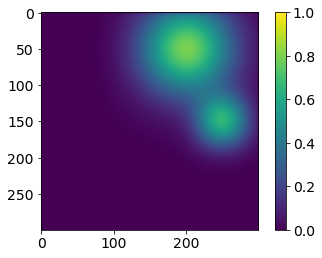

In [ ]:
## Visualization and compare the final result of serial/parallel codes
import numpy as np
# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
import pandas as pd
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

## visualize the serial output
serial_solution = np.load("/content/output/AD_2D_serial.npy")
print(serial_solution.shape)
plt.imshow(serial_solution,vmin=0,vmax=1)
plt.colorbar()

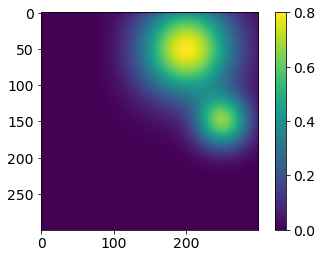

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

subdomains_list = []
num_process = 2
for p_id in range(0,2):
  temp = np.load("/content/output/AD_2D_proc_{}_parallel_{}.npy".format(p_id,num_process))
  subdomains_list.append(temp)
  
# get merged result and then visualize it

# two subdomains ...
parallel_solution = np.concatenate([subdomains_list[0], subdomains_list[1]],axis = 1)
plt.imshow(parallel_solution)
plt.colorbar()

# four subdomains ...
# parallel_solution_1 = np.concatenate([subdomains_list[0],subdomains_list[1]],axis=1) # this time we only need to combine horizontally
# parallel_solution_2 = np.concatenate([subdomains_list[2],subdomains_list[3]],axis=1) # this time we only need to combine horizontally
# parallel_solution = np.concatenate([parallel_solution_1,parallel_solution_2],axis=0)
# print(parallel_solution.shape)
# plt.imshow(parallel_solution)
# plt.colorbar()

# nine domains 
# parallel_solution_1 = np.concatenate([subdomains_list[0],subdomains_list[1],subdomains_list[2]],axis=1) # this time we only need to combine horizontally
# parallel_solution_2 = np.concatenate([subdomains_list[3],subdomains_list[4],subdomains_list[5]],axis=1) # this time we only need to combine horizontally
# parallel_solution_3 = np.concatenate([subdomains_list[6],subdomains_list[7],subdomains_list[8]],axis=1) # this time we only need to combine horizontally
# parallel_solution = np.concatenate([parallel_solution_1,parallel_solution_2,parallel_solution_3],axis=0)
# print(parallel_solution.shape)
# plt.imshow(parallel_solution)
# plt.colorbar()

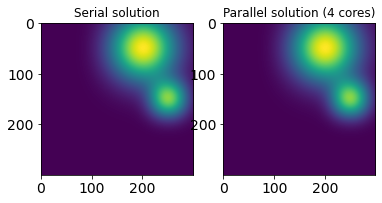

abe: 36.387532625391806
avg abe: 0.00040430591805990895
norm abe: 0.09946372619538124
avg norm abe: 1.1051525132820137e-06


In [ ]:
# compare the visualization 
fig, axes = plt.subplots(1, 2)
axes[0].imshow(serial_solution)
axes[0].title.set_text('Serial solution')
axes[1].imshow(parallel_solution)
axes[1].title.set_text('Parallel solution (4 cores)')

plt.savefig("result_validation.png")
plt.show()
print('abe:',np.sum(np.abs(serial_solution - parallel_solution)))
print('avg abe:',np.sum(np.abs(serial_solution - parallel_solution))/(300*300))
print('norm abe:',np.abs(np.linalg.norm(serial_solution) - np.linalg.norm(parallel_solution)))
print('avg norm abe:',np.abs(np.linalg.norm(serial_solution) - np.linalg.norm(parallel_solution))/(300*300))

## Study of the differences between L1/L2 Norms of the serial and parallel implementation 
Ensure the accuracy error is small enough (indentical). So the parallelisation is valid.

In [ ]:
serial_l1_norms = np.load("/content/norms/AD_2D_serial_l1_norms.npy")
serial_l2_norms = np.load("/content/norms/AD_2D_serial_l2_norms.npy")
serial_linf_norms = np.load("/content/norms/AD_2D_serial_linf_norms.npy")

FileNotFoundError: ignored

In [ ]:
# compute the L1/L2 norms of the parallel implementation
parallel_l1_norms = np.array([])
parallel_l2_norms = np.array([])
parallel_linf_norms = np.array([])
parallel_steps = []

for t in range(1000):
  # 2 sub_domains
  region_1 = np.load("/content/parallel_steps/AD_2D_proc_0_parallel_2_step_{}.npy".format(t))[0,1:-1,1:-1,0]
  region_2 = np.load("/content/parallel_steps/AD_2D_proc_1_parallel_2_step_{}.npy".format(t))[0,1:-1,1:-1,0]

  # 9 sub_domains ...
  # region_1 = np.load("/content/parallel_steps/AD_2D_proc_0_parallel_9_step_{}.npy".format(t))
  # region_2 = np.load("/content/parallel_steps/AD_2D_proc_1_parallel_9_step_{}.npy".format(t))
  # region_3 = np.load("/content/parallel_steps/AD_2D_proc_2_parallel_9_step_{}.npy".format(t))
  # region_4 = np.load("/content/parallel_steps/AD_2D_proc_3_parallel_9_step_{}.npy".format(t))
  # region_5 = np.load("/content/parallel_steps/AD_2D_proc_4_parallel_9_step_{}.npy".format(t))
  # region_6 = np.load("/content/parallel_steps/AD_2D_proc_5_parallel_9_step_{}.npy".format(t))
  # region_7 = np.load("/content/parallel_steps/AD_2D_proc_6_parallel_9_step_{}.npy".format(t))
  # region_8 = np.load("/content/parallel_steps/AD_2D_proc_7_parallel_9_step_{}.npy".format(t))
  # region_9 = np.load("/content/parallel_steps/AD_2D_proc_8_parallel_9_step_{}.npy".format(t))

  # 16 sub_domains ...
  # region_1 = np.load("/content/parallel_steps/AD_2D_proc_0_parallel_16_step_{}.npy".format(t))
  # region_2 = np.load("/content/parallel_steps/AD_2D_proc_1_parallel_16_step_{}.npy".format(t))
  # region_3 = np.load("/content/parallel_steps/AD_2D_proc_2_parallel_16_step_{}.npy".format(t))
  # region_4 = np.load("/content/parallel_steps/AD_2D_proc_3_parallel_16_step_{}.npy".format(t))
  # region_5 = np.load("/content/parallel_steps/AD_2D_proc_4_parallel_16_step_{}.npy".format(t))
  # region_6 = np.load("/content/parallel_steps/AD_2D_proc_5_parallel_16_step_{}.npy".format(t))
  # region_7 = np.load("/content/parallel_steps/AD_2D_proc_6_parallel_16_step_{}.npy".format(t))
  # region_8 = np.load("/content/parallel_steps/AD_2D_proc_7_parallel_16_step_{}.npy".format(t))
  # region_9 = np.load("/content/parallel_steps/AD_2D_proc_8_parallel_16_step_{}.npy".format(t))
  # region_10 = np.load("/content/parallel_steps/AD_2D_proc_9_parallel_16_step_{}.npy".format(t))
  # region_11 = np.load("/content/parallel_steps/AD_2D_proc_10_parallel_16_step_{}.npy".format(t))
  # region_12 = np.load("/content/parallel_steps/AD_2D_proc_11_parallel_16_step_{}.npy".format(t))
  # region_13 = np.load("/content/parallel_steps/AD_2D_proc_12_parallel_16_step_{}.npy".format(t))
  # region_14 = np.load("/content/parallel_steps/AD_2D_proc_13_parallel_16_step_{}.npy".format(t))
  # region_15 = np.load("/content/parallel_steps/AD_2D_proc_14_parallel_16_step_{}.npy".format(t))
  # region_16 = np.load("/content/parallel_steps/AD_2D_proc_15_parallel_16_step_{}.npy".format(t))
   
  # 2 subdomains
  region = np.concatenate([region_1, region_2],axis = 1)
  parallel_steps.append(region)

  # print(region.shape)
  # 9 
  # region_row_1 = np.concatenate([region_1, region_2,region_3],axis = 1)
  # region_row_2 = np.concatenate([region_4, region_5,region_6],axis = 1)
  # region_row_3 = np.concatenate([region_7, region_8,region_9],axis = 1)
  # region = np.concatenate([region_row_1,region_row_2,region_row_3],axis = 0)
  # 16
  # region_row_1 = np.concatenate([region_1, region_2,region_3,region_4],axis = 1)
  # region_row_2 = np.concatenate([region_5,region_6,region_7,region_8],axis = 1)
  # region_row_3 = np.concatenate([region_9, region_10,region_11,region_12],axis = 1)
  # region_row_4 = np.concatenate([region_13, region_14,region_15, region_16],axis = 1)
  # region = np.concatenate([region_row_1,region_row_2,region_row_3,region_row_4],axis = 0)

  parallel_l1_norms = np.append(parallel_l1_norms, np.linalg.norm(region, ord=1)/90000)
  parallel_l2_norms = np.append(parallel_l2_norms, np.linalg.norm(region, ord=2)/90000)
  parallel_linf_norms = np.append(parallel_linf_norms, np.linalg.norm(region, ord=np.inf)/90000)

In [ ]:
# plt.title("L1 norm of serial implementation") 

# plt.plot(serial_l1_norms) 
# plt.xlabel("Time steps")
# plt.ylabel("L1-Norm")
# plt.grid()
# plt.show() 

In [ ]:
# plt.title("L1 norm of parallel implementation")

# plt.plot(parallel_l1_norms) 
# plt.xlabel("Time steps")
# plt.ylabel("L1-Norm")
# plt.grid()
# plt.show() 

In [ ]:
# plt.title("ABE of L1-Norm between serial and parallel")

abe_l1 = np.abs(serial_l1_norms - parallel_l1_norms)

# # print(abe_l1)

# plt.plot(abe_l1) 
# plt.xlabel("Time steps")
# plt.ylabel("ABE-L1-NORM")
# plt.grid()
# plt.show() 

In [ ]:
# plt.title("L2 norm of serial implementation") 

# plt.plot(serial_l2_norms) 
# plt.xlabel("Time steps")
# plt.ylabel("L2-Norm")
# plt.grid()
# plt.show()

In [ ]:
# plt.title("L2 norm of parallel implementation") 

# plt.plot(parallel_l2_norms) 
# plt.xlabel("Time steps")
# plt.ylabel("L2-Norm")
# plt.grid()
# plt.show()

In [ ]:
# plt.title("ABE of L2-Norm between serial and parallel")

abe_l2 = np.abs(serial_l2_norms - parallel_l2_norms)

# # print(abe_l2)

# plt.plot(abe_l1) 
# plt.xlabel("Time steps")
# plt.ylabel("ABE-L2-NORM")
# plt.grid()
# plt.show() 

In [ ]:
# plt.title("L-infinity norm of serial implementation") 

# plt.plot(serial_linf_norms) 
# plt.xlabel("Time steps")
# plt.ylabel("L-Infinity-Norm")
# plt.grid()
# plt.show()

In [ ]:
# plt.title("L-infinity norm of parallel implementation") 

# plt.plot(parallel_linf_norms) 
# plt.xlabel("Time steps")
# plt.ylabel("L-Infinity-Norm")
# plt.grid()
# plt.show()

In [ ]:
# plt.title("ABE of L-Infinity-Norm between serial and parallel")

abe_linf = np.abs(serial_linf_norms - parallel_linf_norms)

# # print(abe_l2)

# plt.plot(abe_linf) 
# plt.xlabel("Time steps")
# plt.ylabel("ABE-L-INF-NORM")
# plt.grid()
# plt.show()

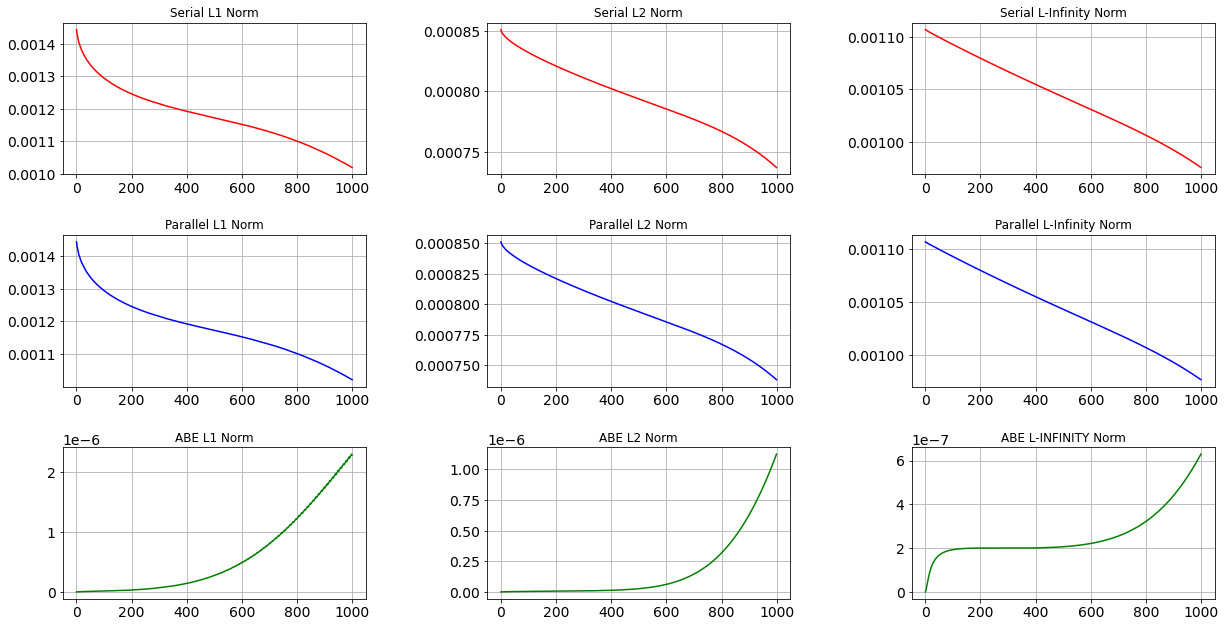

In [ ]:
fig, axes = plt.subplots(3, 3,figsize=(20, 10))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

axes[0, 0].plot(serial_l1_norms,'r')
axes[0,0].title.set_text('Serial L1 Norm')
axes[0, 1].plot(serial_l2_norms,'r')
axes[0,1].title.set_text('Serial L2 Norm')
axes[0, 2].plot(serial_linf_norms,'r')
axes[0,2].title.set_text('Serial L-Infinity Norm')

axes[1, 0].plot(parallel_l1_norms, 'b')
axes[1,0].title.set_text('Parallel L1 Norm')
axes[1, 1].plot(parallel_l2_norms, 'b')
axes[1,1].title.set_text('Parallel L2 Norm')
axes[1, 2].plot(parallel_linf_norms, 'b')
axes[1,2].title.set_text('Parallel L-Infinity Norm')

axes[2, 0].plot(abe_l1, 'g')
axes[2,0].title.set_text('ABE L1 Norm')
axes[2, 1].plot(abe_l2, 'g')
axes[2,1].title.set_text('ABE L2 Norm')
axes[2, 2].plot(abe_linf, 'g')
axes[2,2].title.set_text('ABE L-INFINITY Norm')


axes[0,0].grid()
axes[0,1].grid()
axes[0,2].grid()
axes[1,0].grid()
axes[1,1].grid()
axes[1,2].grid()
axes[2,0].grid()
axes[2,1].grid()
axes[2,2].grid()

plt.savefig("accuracy_study.png")
plt.show()

## Spot the accuracy issue by comparing the spatial difference

In [ ]:
serial_steps = []
# parallel_steps = np.array([])

# load the spatial record of the serial code
for t in range(1000):
  region = np.load("/content/serial_steps/AD_2D_serial_step_{}.npy".format(t))
  serial_steps.append(region)

In [ ]:
spatial_diffs = []
for t in range(1000):
  spatial_diffs.append(abs(serial_steps[t] - parallel_steps[t]))

KeyboardInterrupt: ignored

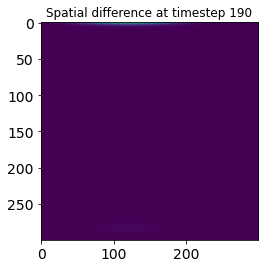

In [ ]:
! mkdir spatial_diffs

# made up to 500 time-steps
for t in range(500):
  plt.title('Spatial difference at timestep {}'.format(t))
  plt.imshow(spatial_diffs[t])
  plt.savefig('/content/spatial_diffs/spatial_diff_step_{}.png'.format(t))


In [ ]:
# generate the video
import cv2
import os

image_folder = '/content/spatial_diffs'
video_name = 'spatial_differences.mp4'

images = []

for i in range(500):
  img = cv2.imread('/content/spatial_diffs/spatial_diff_step_{}.png'.format(i))
  images.append(img) 

# images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = images[0]
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
video = cv2.VideoWriter(video_name, fourcc, 1, (width,height))

for image in images:
    video.write(image)

cv2.destroyAllWindows()
video.release()

## Check accuracy error from the video

In [ ]:
from IPython.display import HTML
from base64 import b64encode

video_path = '/content/spatial_differences.mp4'
 
def show_video(video_path, video_width = 600):
   
  video_file = open(video_path, "r+b").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")
 
show_video(video_path)